In [3]:
%matplotlib inline
import sys
import os
import pathlib
sys.path.append(os.path.join('../'))
from lib.sat_manager import VIIRS, modis
from lib.functions import fluxnet, icos
from VPRM import vprm 
import yaml
import glob
import time
import numpy as np
import pandas as pd
import pickle
import argparse
from functions import lat_lon_to_modis
from tzwhere import tzwhere
import pytz
from dateutil import parser
from fancy_plot import *
import datetime

In [16]:
all_data = []
for f in glob.glob('./site_data_for_fit_modis/*'):
    with open(f, 'rb') as ifile:
        all_data.append(pickle.load(ifile))
all_data = np.concatenate(all_data)

In [6]:
# with open('../configs/config_draft.yaml', "r") as stream:
#     try:
#         cfg  = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)

# veg_type_id = {'GRA': 7, 'MF': 3 , 'CRO':6, 
#                'EF': 1, 'DF': 2, 'SH':4, 'WET':9}
# # GRA = Grassland | MF = Mixed Forest | CRO = Cropland | EF = Evergreen Forest | DF = Deciduous Forest | SH = Shrubland

# # site_info = pd.read_pickle('../fluxnet_info/fluxnet_sites.pkl')
# all_data = []
# vprm_insts = []
# for this_year in [2012]: # 2012 
#     print(this_year) 

#     if this_year == 2012:
#         site_list ={'EF': ['DE-Tha']}
#       #  site_list= {'GRA': [ 'CH-Fru', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor'], # 'CZ-BK2'  'AT-Neu' 'CH-Cha'
#       #                       'MF': ['BE-Bra', 'BE-Vie', 'CH-Lae'],
#       #                       'CRO': [ 'DE-Geb', 'DE-Kli', 'FR-Gri'], # 'IT-BCi' 'DE-RuS' # 'BE-Lon'  'CH-Oe2', 'IT-CA2'
#       #                       'EF': ['CZ-BK1', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 
#       #                                    'IT-Lav', 'IT-Ren',  'NL-Loo'],# 'IT-SRo' 'FI-Sod', 'RU-Fyo' 'DE-Lkb' 'CH-Dav'
#       #                     #  'wetland': ['CZ-wet', 'DE-Akm', 'DE-SfN', 'DE-Spw', 'FR-Pue', 'IT-Cp2'],
#       #                       'DF': ['DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-Col', 'IT-Ro2'], # 'IT-CA3' # 'IT-CA1'
#       #                       'SH': []} #  'ES-Amo' 'ES-LJu' # 'IT-Noe' 
#     elif this_year==2021:
#         site_list = {'CRO': ['DE-RuS']}
#         # site_list= {'GRA': ['FR-Mej'],  # 'IT-Niv'
#         #                   'MF': ['DE-Har'],
#         #                   'CRO': ['FR-Aur', 'DK-Vng'],
#         #                   'EF': ['SE-Nor', 'FI-Ken',
#         #                          'FI-Var', 'SE-Svb', 'SE-Htm',  ], # FR-Bil # 'FR-Hes' 'DE-RuW' 'DK-Gds
#         #                   'wetland': ['FR-LGt', 'DK-Skj', 'SE-Deg'], # 'DE-Msr',  # 'SE-Sto'
#         #                   'DF': ['DE-HoH'], # 'CZ-Lnz'
#         #                   'SH': ['BE-Maa']} # IT-Lsn

#     site_dict = dict()

#     ## ---------------- Load Fluxtower Data -------------------
#     for hv in cfg['hvs']:

#         h = hv[0]
#         v = hv[1]
#         all_sites = np.concatenate([site_list[i] for i in site_list.keys()])

#         tmin = parser.parse('{}0101'.format(this_year))
#         tmax = parser.parse('{}1231'.format(this_year))
#         lonlats = []
#         tower_data_list = []
#         for s in all_sites:
#             # if len(tower_data_list) >1:
#             #     continue
#             if this_year == 2012:
#                 data_files = glob.glob(os.path.join(cfg['fluxnet_path'], '*{}*/*_FULLSET_H*'.format(s)))
#                 if len(data_files) == 0: continue
#                 flux_tower_inst = fluxnet(data_files[0],'SW_IN_F', 'TA_F',
#                                           t_start= tmin, t_stop=tmax)
#             elif this_year == 2021:
#                 data_files = glob.glob(os.path.join(cfg['icos_path'], '*/*_{}_FLUXNET_HH_L2.csv'.format(s)))
#                 if len(data_files) == 0: continue
#                 flux_tower_inst = icos(data_files[0],'SW_IN_F', 'TA_F', 
#                                         t_start= tmin, t_stop=tmax)
#             lon = flux_tower_inst.get_lonlat()[0]
#             lat= flux_tower_inst.get_lonlat()[1]
#             hv = lat_lon_to_modis(lat, lon)
#             if not ((hv[0] == h) & (hv[1] == v)): continue
#             okay = flux_tower_inst.add_tower_data()
#             if not okay: continue
#             print(flux_tower_inst.get_site_name())
#    #         print(flux_tower_inst.get_data())
#             for key in site_list.keys():
#                 if s in site_list[key]:
#                     veg_type = veg_type_id[key]
#             flux_tower_inst.set_land_type(veg_type)

#             tower_data_list.append(flux_tower_inst)
#             lonlats.append((lon, lat))
        
#         if len(tower_data_list) == 0: continue

#         # ----------- Using the new VPRM Processing Code --------------------

#         vprm_inst = vprm(n_cpus=1, sites=tower_data_list)

#         # Use data satellite for one year and add two images from the previous and following year to avoid boundary effects

#         inp_files1 = sorted(glob.glob(os.path.join(cfg['sat_image_path'], str(this_year-1),
#                                                             '*h{:02d}v{:02d}*.h*'.format(h, v))))[-3:]
#         inp_files2 = sorted(glob.glob(os.path.join(cfg['sat_image_path'], str(this_year),
#                                                             '*h{:02d}v{:02d}*.h*'.format(h, v))))
#         inp_files3 = sorted(glob.glob(os.path.join(cfg['sat_image_path'], str(this_year+1),
#                                                             '*h{:02d}v{:02d}*.h*'.format(h, v))))[:3]

#         inp_files = np.concatenate([inp_files1, inp_files2, inp_files3])
#         _, inds = np.unique([os.path.basename(f) for f in inp_files], 
#                           return_index=True)
#         inp_files = inp_files[inds]
        
#         for c, i in enumerate(inp_files):
#             print(i)
#             if cfg['satellite'] == 'modis':
#                 handler = modis(sat_image_path=i)
#                 handler.load()
#                 vprm_inst.add_sat_img(handler, b_nir='sur_refl_b02',
#                                       b_red='sur_refl_b01',
#                                       b_blue='sur_refl_b03',b_swir='sur_refl_b06',
#                                       which_evi='evi', 
#                                       timestamp_key='sur_refl_day_of_year',
#                                       mask_bad_pixels=True,
#                                       mask_clouds=True,
#                                       drop_bands=True)
#             else:
#                 handler = VIIRS(sat_image_path=i)
#                 handler.load()
#                 vprm_inst.add_sat_img(handler, b_nir='SurfReflect_I2', b_red='SurfReflect_I1',
#                                   b_blue='no_blue_sensor', b_swir='SurfReflect_I3',
#                                   which_evi='evi2',
#                                   drop_bands=True)

#         # Uncomment if you want to do a spatial smearing with size=(3,3). Otherwise give size manually.
#       #  vprm_inst.smearing(lonlats=lonlats)

#         # Sort the satellite images by time and merge internally for easier computations
#         vprm_inst.sort_and_merge_by_timestamp()
#         vprm_inst.reduce_along_lat_lon()
#         print('Do lowess')
#         # Run lowess smoothing
#         # vprm_inst.lowess(keys = ['evi', 'lswi'],
#         #                  times='daily', frac=0.2, it=3)

#         # Calculate necessary parameters for the vprm calculation
#         vprm_inst.calc_min_max_evi_lswi()
#         # vprm_insts.append(vprm_inst)
#         # continue
#         # ------------------------------------------------------------------

#         # Loop over the year and get the vprm_variables
#         data_list = vprm_inst.data_for_fitting()
#         all_data.append(data_list)
# all_data = np.concatenate(all_data)

2012



KeyboardInterrupt



In [98]:
#data = flux_tower_inst.get_data()

In [99]:
# fig = plt.figure(figsize=figsize(0.6, ratio=1.6))
# ax = fig.add_axes((0,0, 1.0, 0.3))
# ax.plot(data['datetime_utc'][12000:13000],
#         data['RECO_DT_VUT_REF'][12000:13000],
#         label='GPP')
# ax.set_ylabel(r'Resp. [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]')

# ax2 = fig.add_axes((0,0.35, 1.0, 0.3))
# ax2.plot(data['datetime_utc'][12000:13000],
#         data['GPP_DT_VUT_REF'][12000:13000],
#         label='GPP')
# ax2.set_xticklabels([])
# ax2.set_ylabel(r'GPP [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]')

# ax3 = fig.add_axes((0,0.7, 1.0, 0.3))
# ax3.plot(data['datetime_utc'][12000:13000],
#         data['NEE_VUT_REF'][12000:13000],
#         label='GPP')
# ax3.set_xticklabels([])
# ax3.set_ylabel(r'NEE [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]')



# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# fig.savefig('/home/b/b309233/plot_for_presentation/tower_flux_example.png', dpi=300, bbox_inches='tight',
#             transparent=False, facecolor='white')
# fig.show()

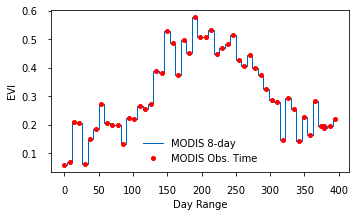

In [33]:
# fig, ax = newfig(0.8)
# ax.plot(vprm_inst.sat_imgs.sat_img['time'], vprm_inst.sat_imgs.sat_img['evi'],
#         drawstyle='steps-mid', color=colors[0], label='MODIS 8-day')
# ax.plot(vprm_inst.sat_imgs.sat_img['time'], vprm_inst.sat_imgs.sat_img['evi'],
#         drawstyle='steps-mid', color='red', marker='o', linestyle='',
#         ms=4, label='MODIS Obs. Time')
# # vprm_inst.lowess(keys = ['evi', 'lswi'],
# #                  times='daily', frac=0.2, it=3)
# # ax.plot(vprm_inst.sat_imgs.sat_img['time_gap_filled'], vprm_inst.sat_imgs.sat_img['evi'],
# #         drawstyle='steps-mid',color=colors[5],
# #         label='Lowess')
# ax.set_xlabel('Day Range')
# ax.set_ylabel('EVI')
# ax.legend(loc='best', frameon=False)
# fig.savefig('/home/b/b309233/plot_for_presentation/lowess.png', dpi=300,
#             bbox_inches='tight')
# fig.show()

In [77]:
# fig, ax = newfig(0.9)
# print(all_data[i].site_name)
# ax.plot(range(len(vprm_inst.get_data()['evi'])), vprm_inst.get_data()['evi'])
# vprm_inst.lowess(keys = ['evi', 'lswi'],
#                  times='daily', frac=0.2, it=3)
# ax.plot(range(len(vprm_inst.get_data()['evi'])), vprm_inst.get_data()['evi'])
# fig.show()

In [78]:
# for i in range(1):
#     fig, ax = newfig(0.9)
#     print(all_data[i].site_name)
#     ax.plot(range(len(all_data[i].get_data()['lswi'])), all_data[i].get_data()['lswi'])
#     fig.show()

In [79]:
# {7: {'respiration': array([0.31636985, 1.95071263]),
#   'gpp': array([1.30919409e-01, 5.24741592e+02])},
#  1: {'respiration': array([0.19078572, 1.58536532]),
#   'gpp': array([1.53387667e-01, 5.84729745e+02])},
#  6: {'respiration': array([0.13730729, 0.83425389]),
#   'gpp': array([9.70116445e-02, 5.61850828e+02])},
#  2: {'respiration': array([0.1513622, 1.6306712]),
#   'gpp': array([1.51435883e-01, 3.92760647e+02])},
#  4: {'respiration': array([0.10218905, 1.11538666]),
#   'gpp': array([1.35763556e-01, 4.82935758e+02])},
#  3: {'respiration': array([0.20417055, 1.84339011]),
#   'gpp': array([1.51832799e-01, 4.44576619e+02])}}

In [80]:
# for a in all_data:
#     print(len(np.where(a.get_data()['TA_F_QC'].values == 0)[0])/len(a.get_data()['TA_F_QC'].values))

In [8]:
gpp_key = 'GPP_DT_VUT_REF'
nee_key = 'NEE_VUT_REF'
reco_key = 'RECO_DT_VUT_REF'

In [26]:
all_data_filtered = []
for i in range(len(all_data)):
    data_for_fit = all_data[i].get_data()
    ws = data_for_fit['WS']
    all_data[i].flux_data = data_for_fit[(ws>0) & (ws<2.5) & (data_for_fit['NEE_VUT_REF_QC'] == 0 )]
    if np.all(np.isfinite(all_data[i].flux_data['lswi'].values)):
        all_data_filtered.append(all_data[i])

In [27]:
vprm_inst = vprm()
variable_dict = {'gpp': gpp_key, 'respiration': reco_key}
best_fit_params = vprm_inst.fit_vprm_data(data_list=all_data_filtered,
                                          variable_dict=variable_dict)

In [28]:
# with open('/home/b/b309233/modis.pickle', 'rb') as ifile:
#     print(pickle.load(ifile))

In [29]:
# with open('/home/b/b309233/modis.pickle', 'wb') as ofile:
#     pickle.dump(best_fit_params, ofile)

In [30]:
# for k in sorted(best_fit_params.keys()):
#     print(k, ' & {:.2f} & {:.2f} & {:.2f} &  {:.2f} \\\\'.format(best_fit_params[k]['lamb'],
#                                                              best_fit_params[k]['par0'],
#                                                              best_fit_params[k]['alpha'],
#                                                              best_fit_params[k]['beta']))

In [31]:
veg_type_id = {'GRA': 7, 'MF': 3 , 'CRO':6, 
               'EF': 1, 'DF': 2, 'SH':4,  'WET':9}
inv_map = {v: k for k, v in veg_type_id.items()}

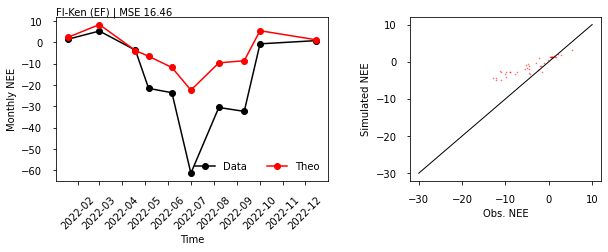

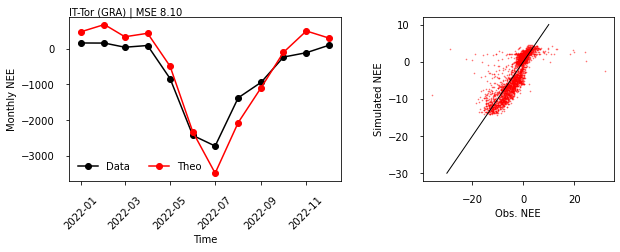

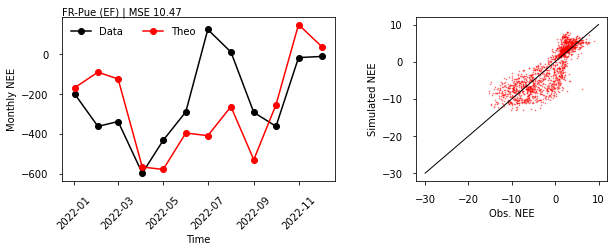

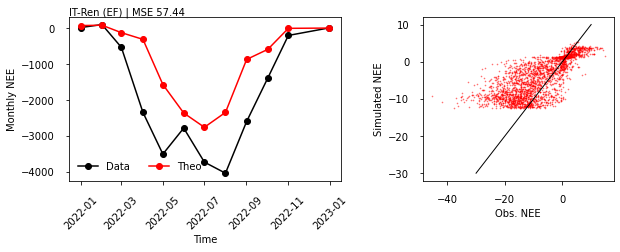

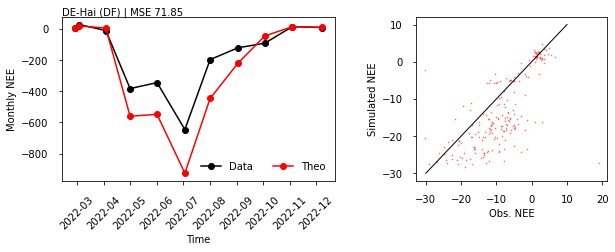

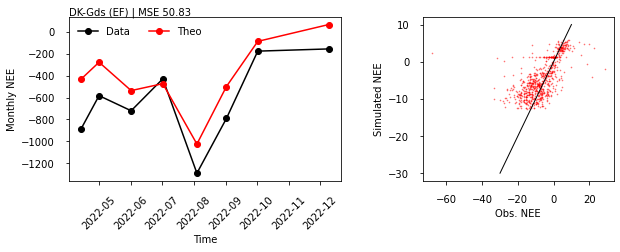

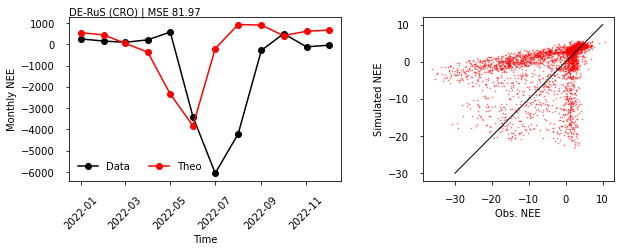

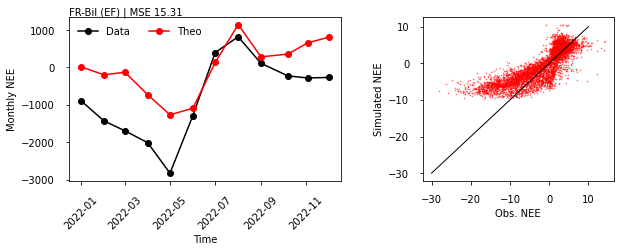

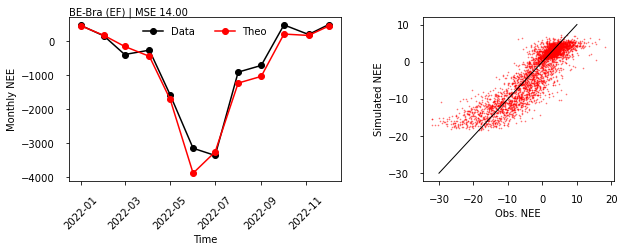

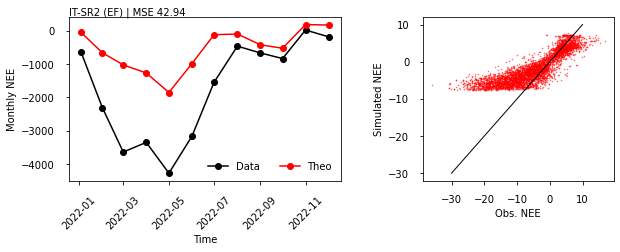

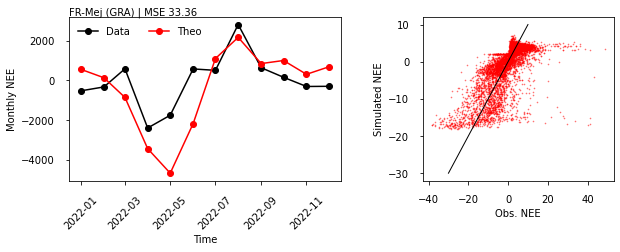

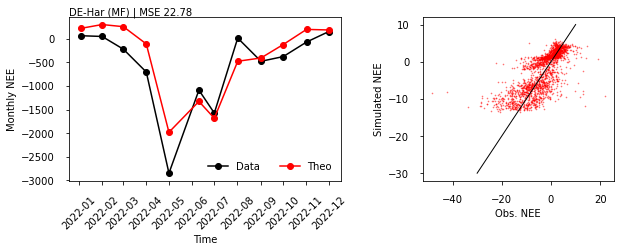

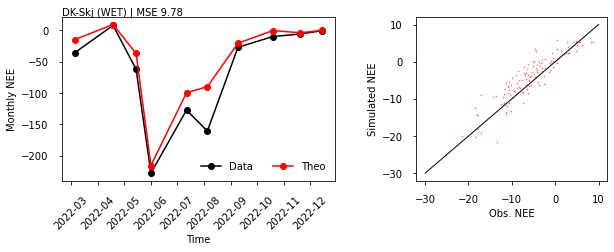

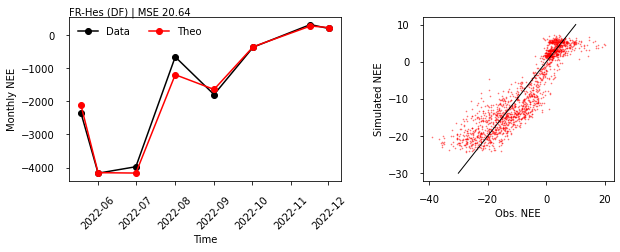

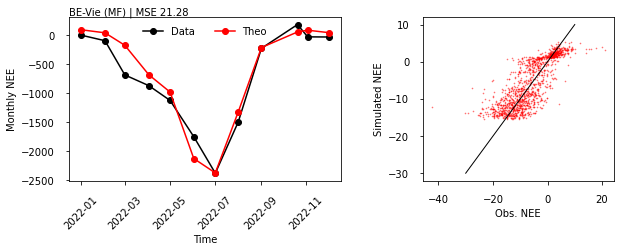

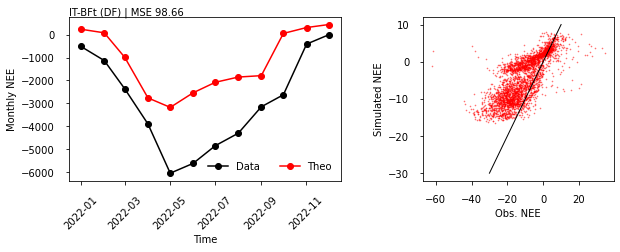

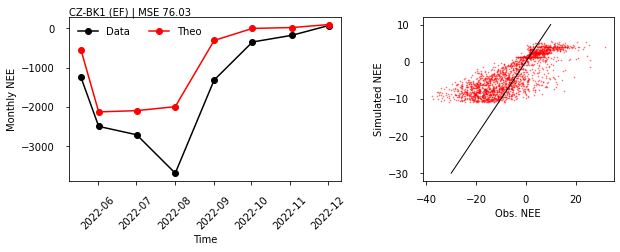

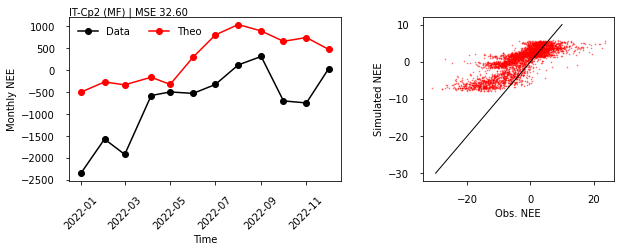

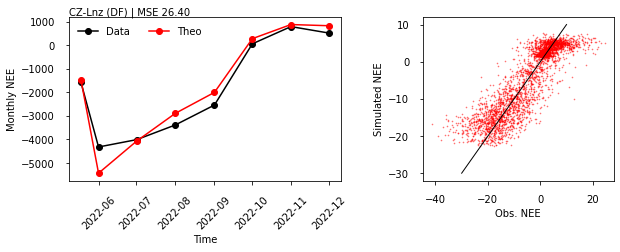

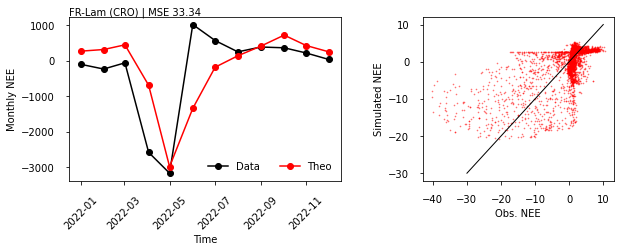

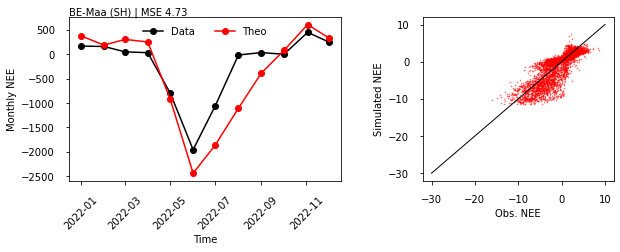

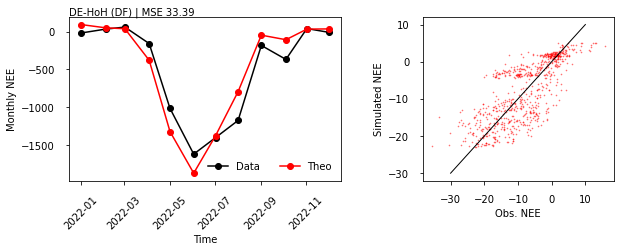

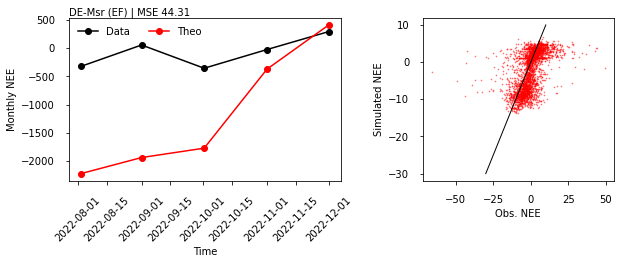

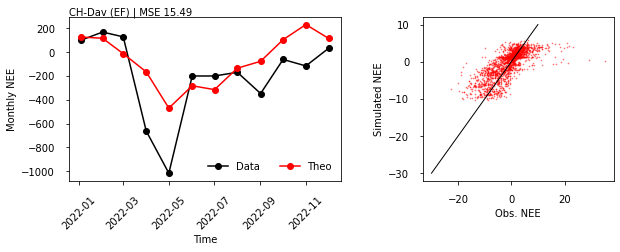

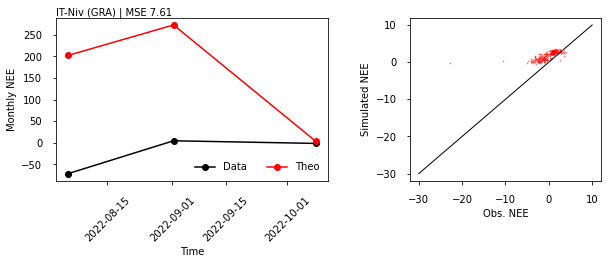

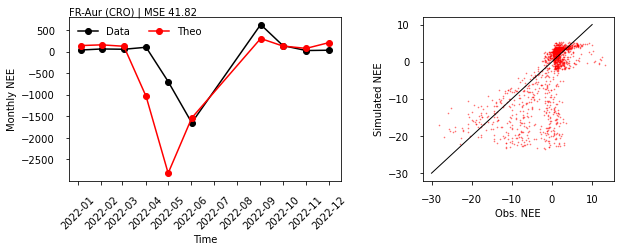

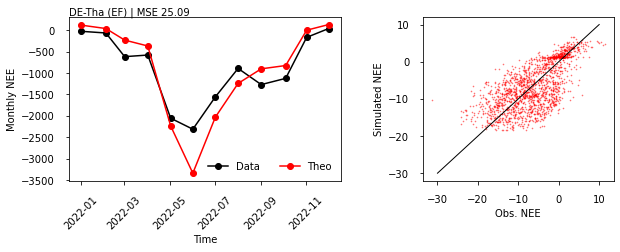

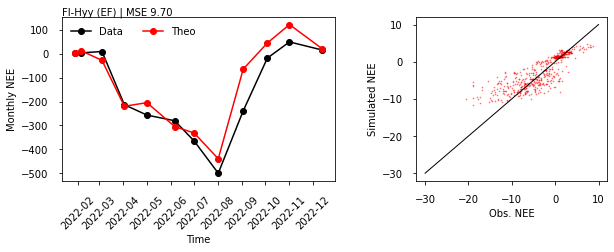

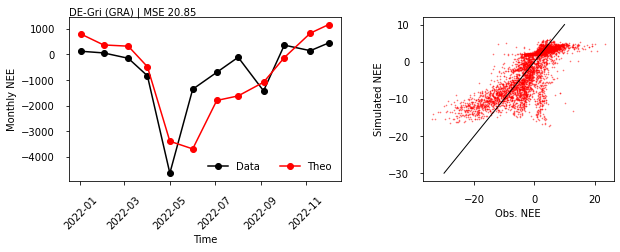

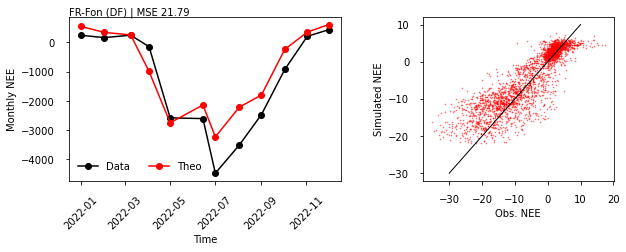

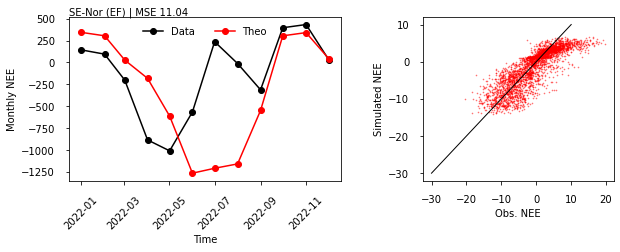

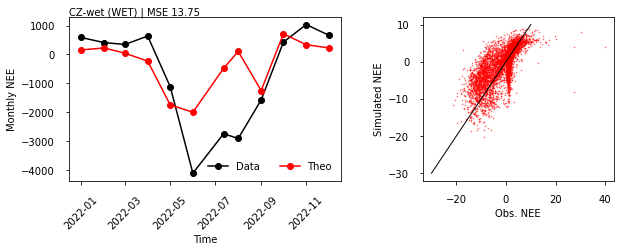

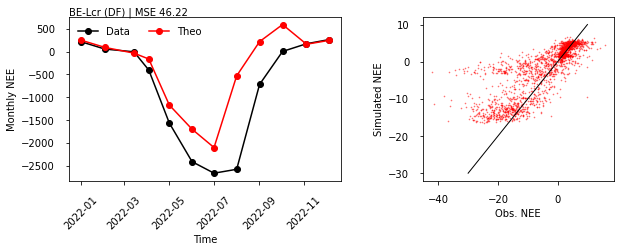

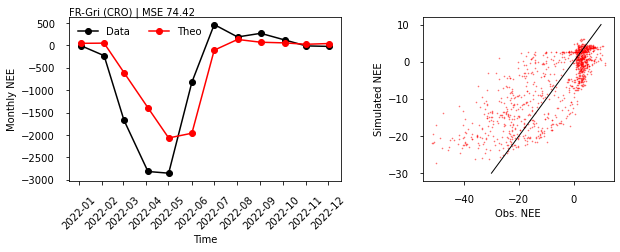

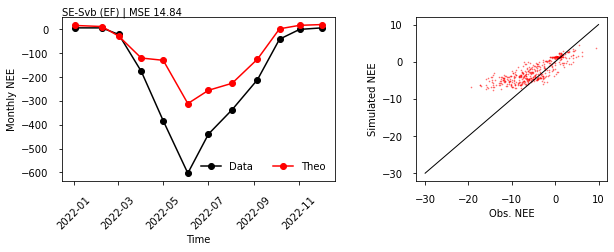

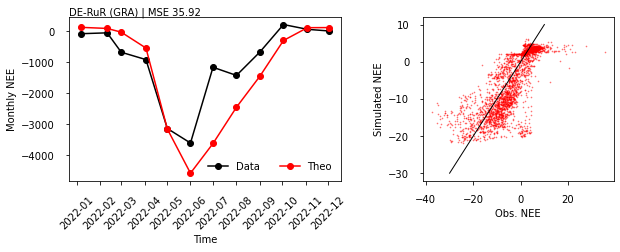

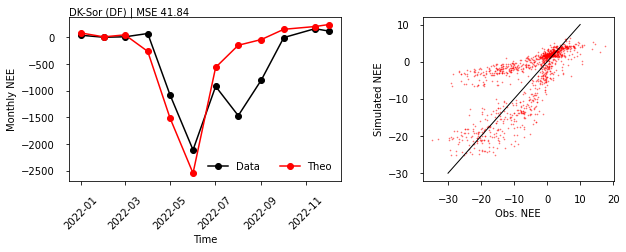

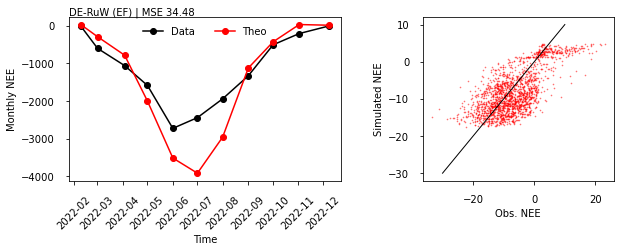

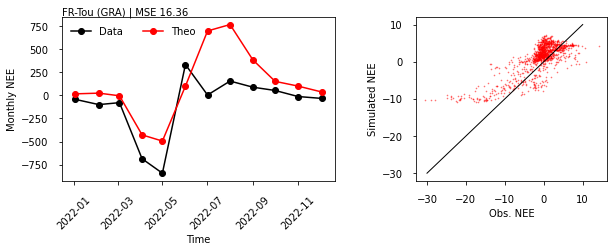

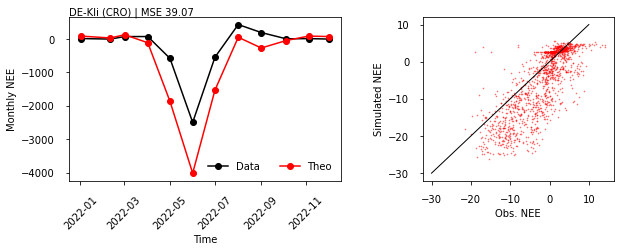

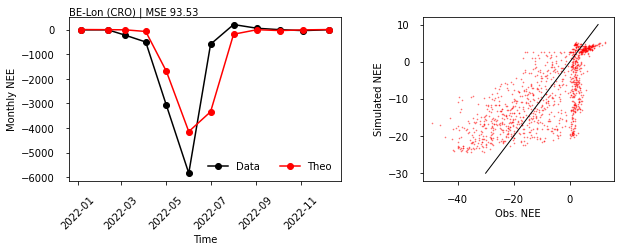

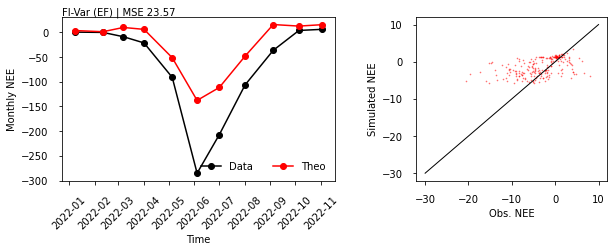

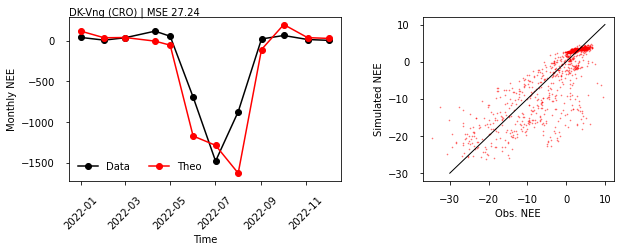

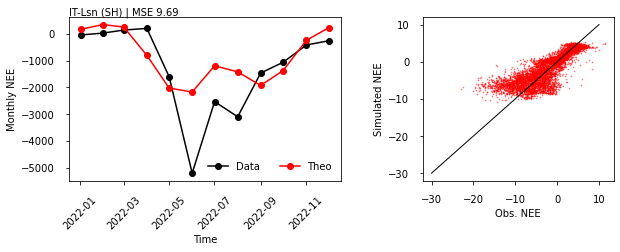

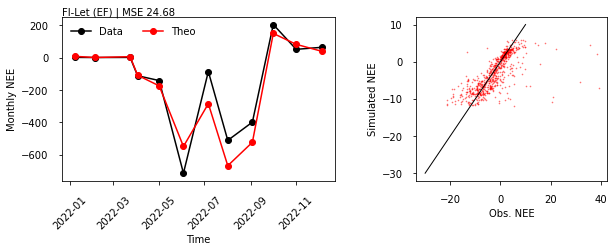

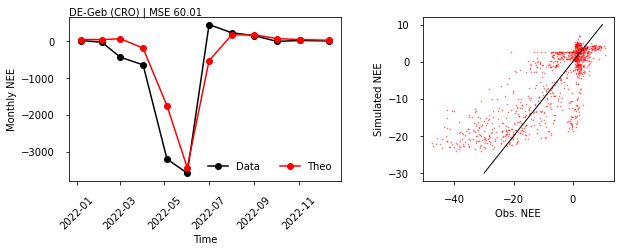

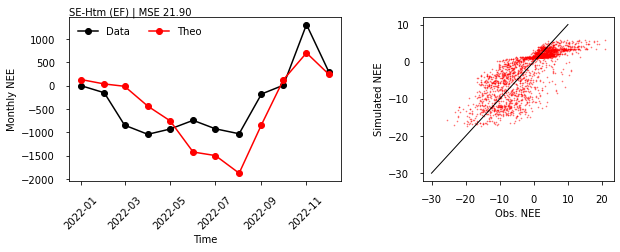

In [32]:
for i in all_data_filtered:
    # if i.site_name != 'IT-Niv':
    #     continue
#    idata_junwei = pd.read_csv(glob.glob('/home/b/b309233/JunweiLi_VPRM_Simulate/*_{}.csv'.format(i.site_name))[0])
    data_for_fit = i.get_data()
 #   data_for_fit = data_for_fit[data_for_fit['NEE_CUT_REF_QC']<=1][::2]
  #  data_for_fit = data_for_fit[:-1]
    veg_type = i.get_land_type()
    gpp = best_fit_params[veg_type]['lamb'] * data_for_fit['Ws'] * data_for_fit['Ts'] * data_for_fit['Ps'] * data_for_fit['evi'] * data_for_fit['par'] / (1 + data_for_fit['par']/best_fit_params[veg_type]['par0'])
    respiration = best_fit_params[veg_type]['alpha'] * data_for_fit['tcorr'] + best_fit_params[veg_type]['beta']
    pred = -gpp + respiration
    #pred[pred<0] = -gpp 
    data_for_fit['pred'] = pred
    
    
    fig = plt.figure(figsize=figsize(1.2, ratio=0.3))
    ax = fig.add_axes((0.0, 0.0, 0.5, 1.0))
    ax2 = fig.add_axes((0.65, 0.0, 0.35, 1.0))
    ax2.scatter(data_for_fit[nee_key],  data_for_fit['pred'], alpha=0.5, color='red', s=0.4)
#    ax2.scatter(idata_junwei['GPP_NT_VUT_REF'], -idata_junwei['Simulate_GEE'], alpha=0.5, color='blue', s=0.4)
    ax2.plot([-30, 10], [-30,10], color='k')
    
    mse = np.mean((data_for_fit[nee_key].values - data_for_fit['pred'].values)**2)
    
    monthly_data = data_for_fit.groupby(pd.Grouper(key='datetime_utc', freq='M'))
    monthly_data = [group for _,group in monthly_data]
    pred = []
    true = []
    month_count = []
    for m in monthly_data:
        if len(m['datetime_utc'].values) ==0:
            continue
        pred.append(m['pred'].sum())
        true.append(m[nee_key].sum())
        month_count.append(m['datetime_utc'].values[0])
    ax.plot(month_count, true,
            color='k', lw=1.5, label='Data',
            marker='o')
    ax.plot(month_count, pred, color='red',
            lw=1.5, label='Theo',
            marker='o')
    # ax.plot(data_for_fit['datetime_utc'].values, data_for_fit[gpp_key],
    #         color='k', lw=1.5, label='Data')
    # ax.plot(data_for_fit['datetime_utc'].values, data_for_fit['pred'], color='red', lw=1.5, label='Theo')
 #   times = [parser.parse(dt) for dt in idata_junwei['Unnamed: 0'].values]
  #  ax.plot(times, idata_junwei['LSWI'], color='blue', lw=1.5, label='Junwei')
    ax.legend(loc='best', ncol=3, frameon=False)
    # ax.set_xlim(parser.parse('2012-08-06'),
    #             parser.parse('2012-08-12'))
    # ax.set_xlim(19000, 19010)
    # ax.set_xticks([])
    ax.set_xlabel('Time')
    ax.set_ylabel('Monthly NEE')
    ax2.set_xlabel('Obs. NEE')
    ax2.set_ylabel('Simulated NEE')
    ax.text(0.0, 1.0, '{} ({}) | MSE {:.2f}'.format(i.site_name, inv_map[i.get_land_type()], mse),
         horizontalalignment='left',
         verticalalignment='bottom',
         transform = ax.transAxes)
    ax.tick_params(axis='x', rotation=45)
    fig.savefig('/home/b/b309233/plot_for_presentation/compare_{}.jpg'.format(i.site_name), bbox_inches='tight',
                dpi=300)
    fig.show()


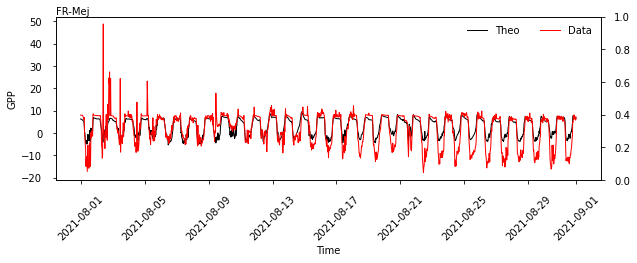

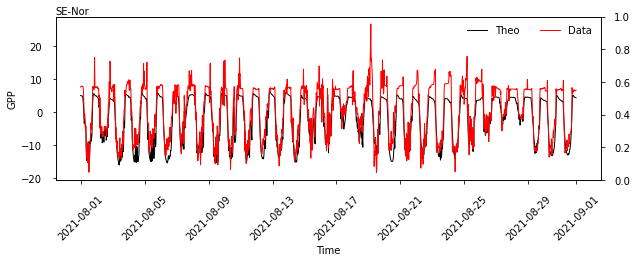

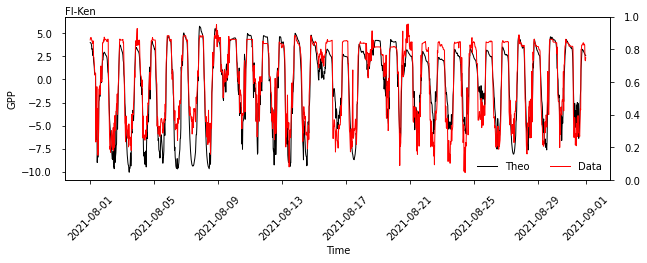

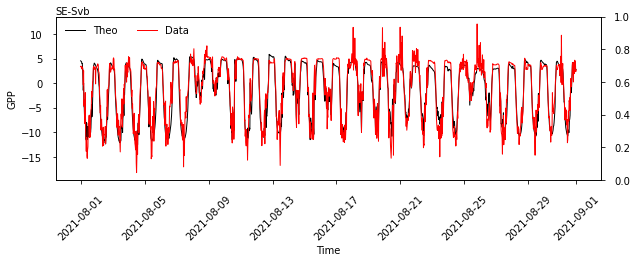

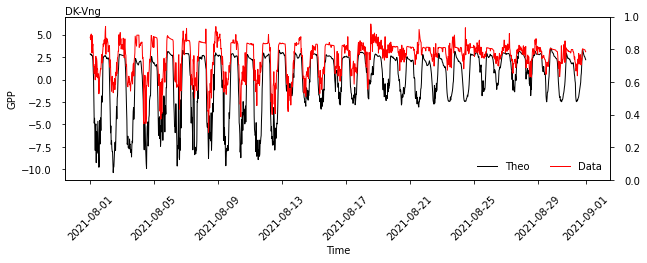

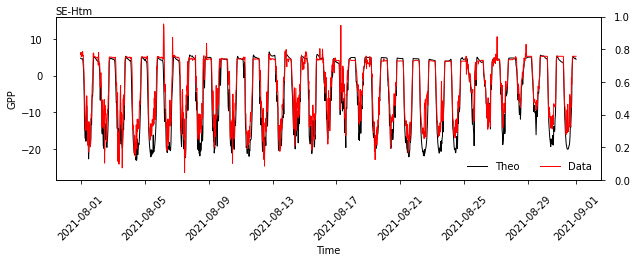

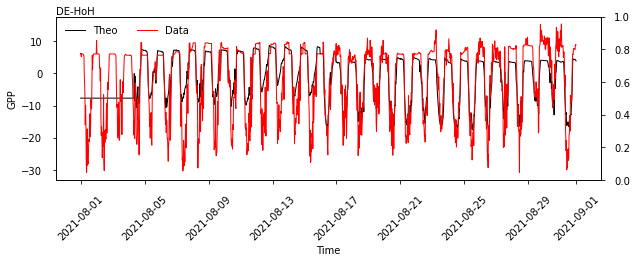

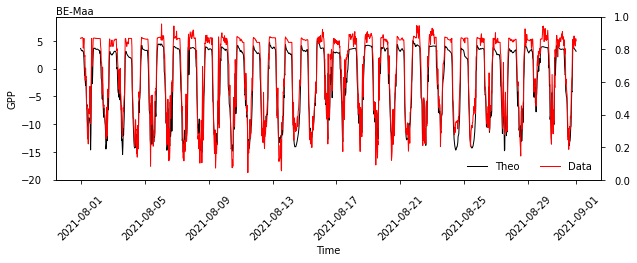

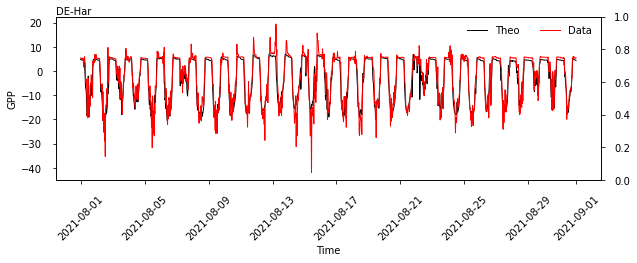

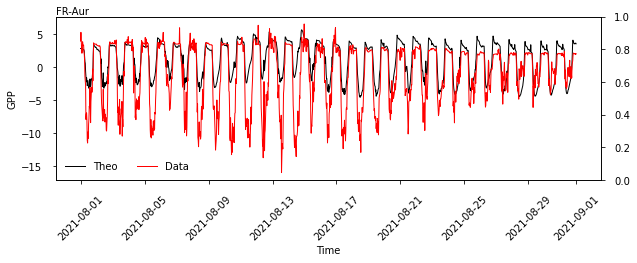

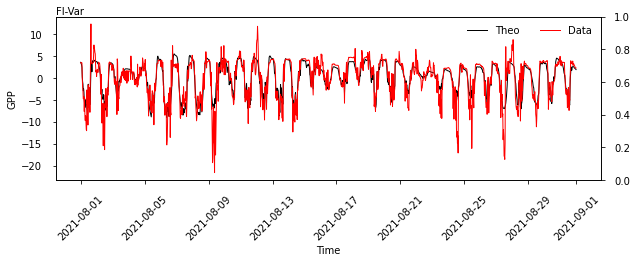

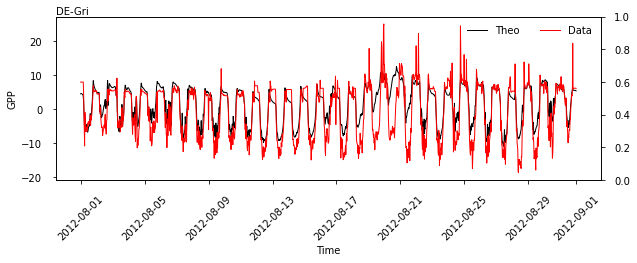

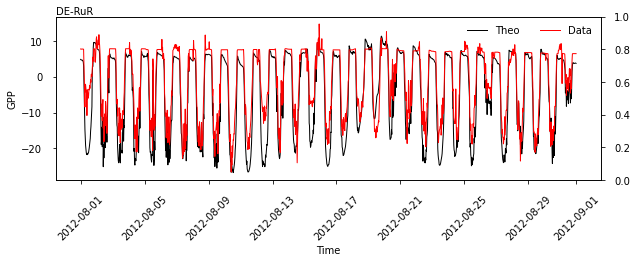

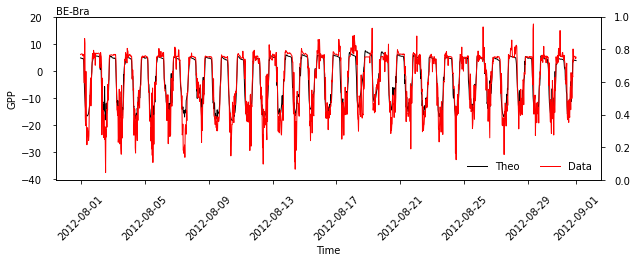

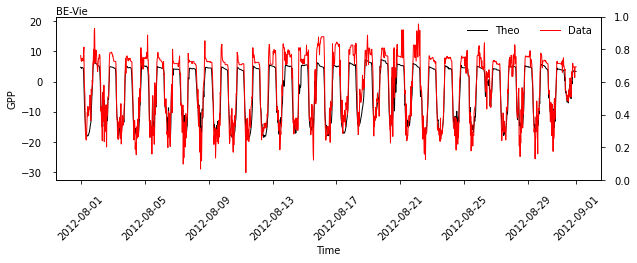

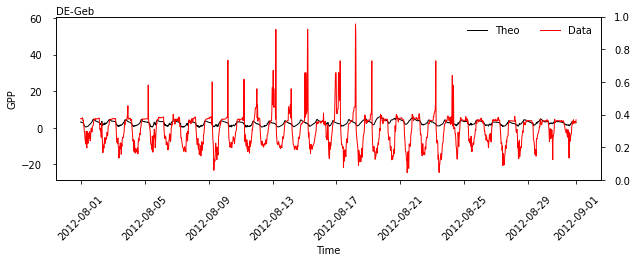

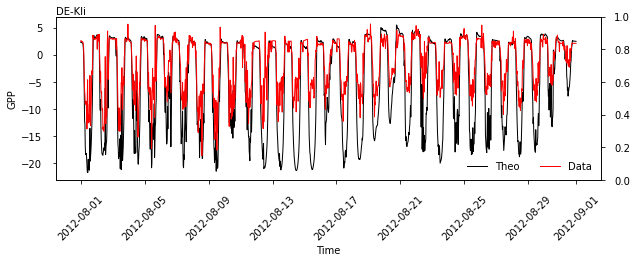

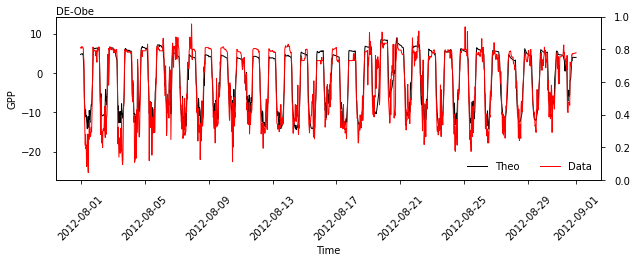

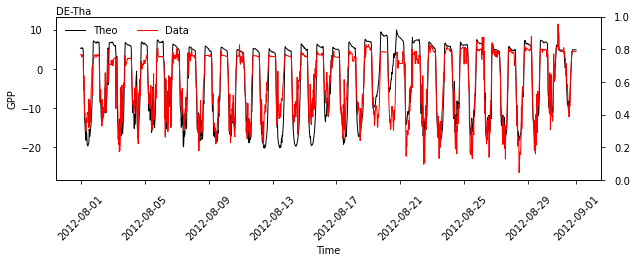

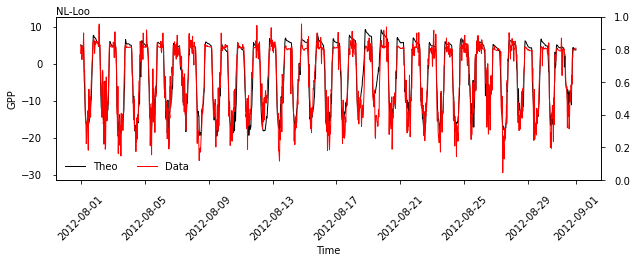

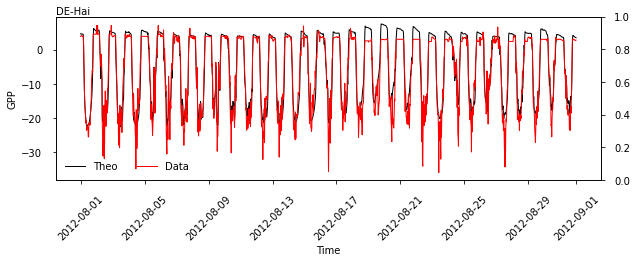

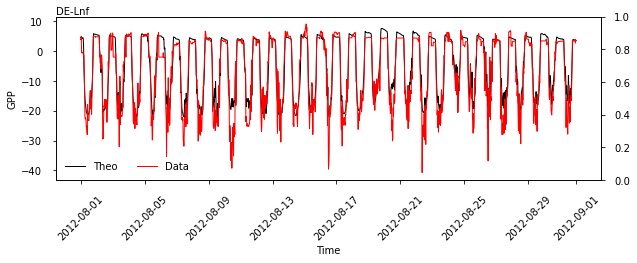

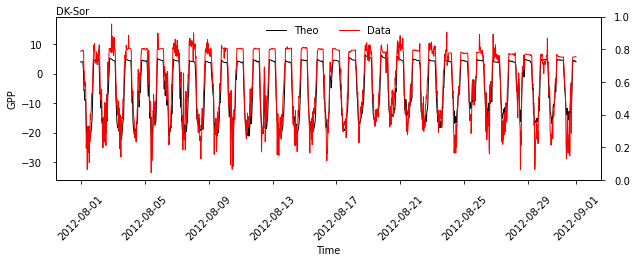

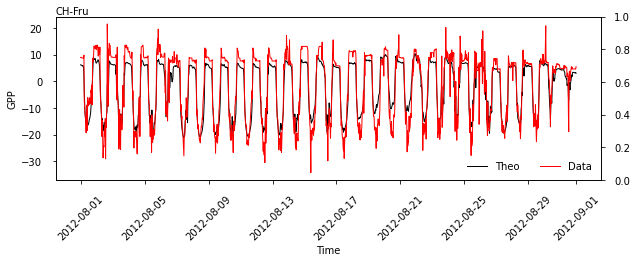

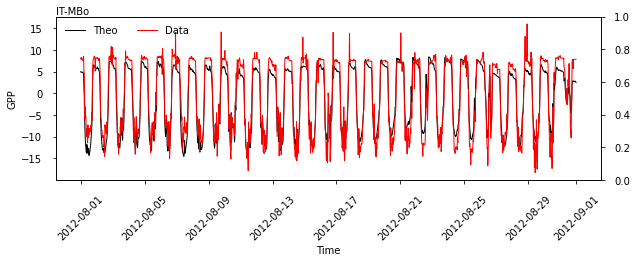

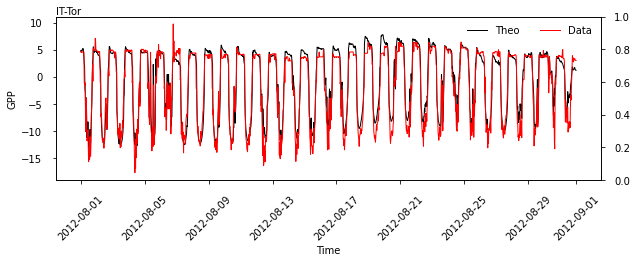

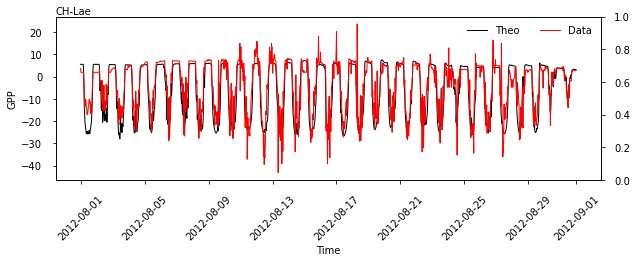

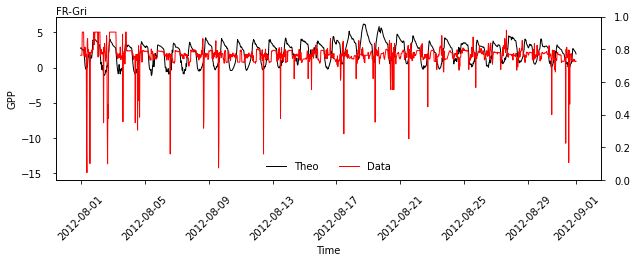

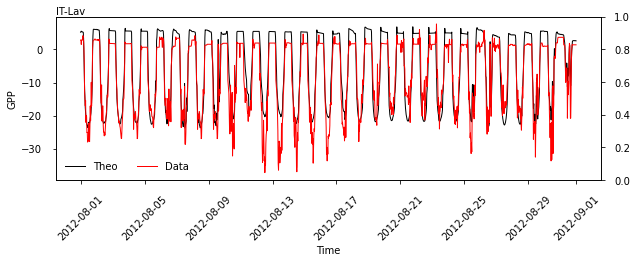

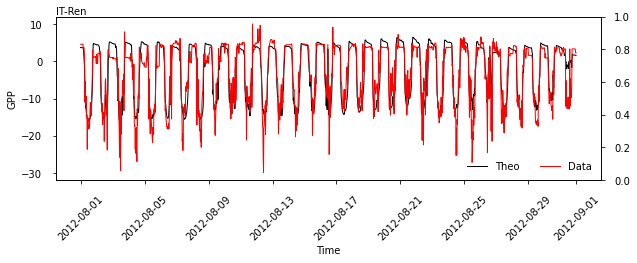

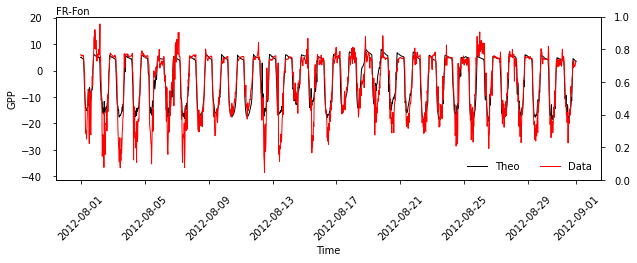

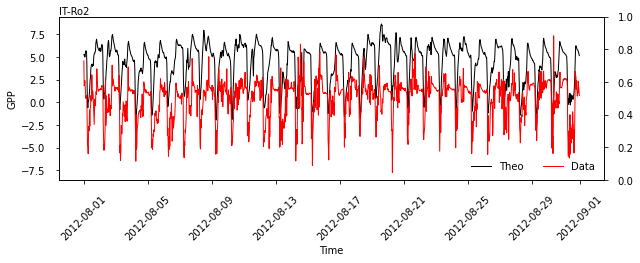

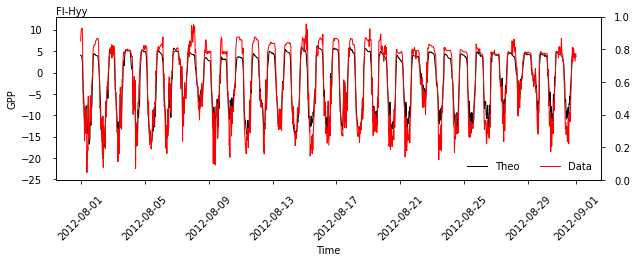

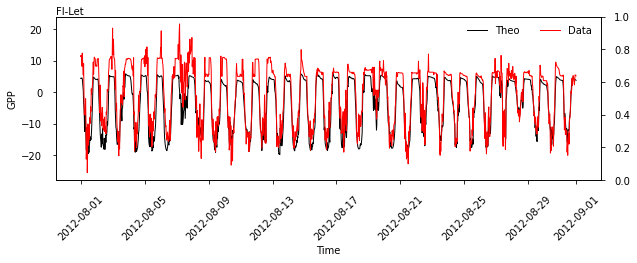

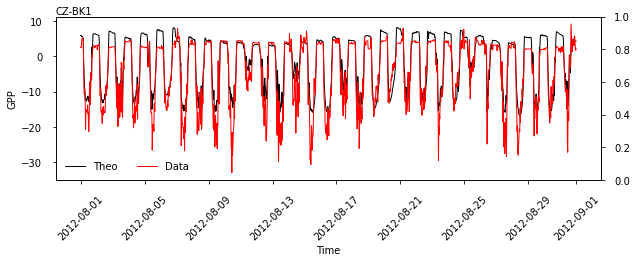

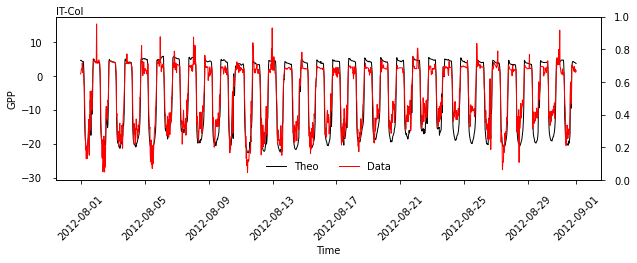

In [10]:
for i in all_data:
    # if i.site_name != 'IT-Niv':
    #     continue
#    idata_junwei = pd.read_csv(glob.glob('/home/b/b309233/JunweiLi_VPRM_Simulate/*_{}.csv'.format(i.site_name))[0])
    data_for_fit = i.get_data()
 #   data_for_fit = data_for_fit[data_for_fit['NEE_CUT_REF_QC']<=1][::2]
  #  data_for_fit = data_for_fit[:-1]
    veg_type = i.get_land_type()
    gpp = best_fit_params[veg_type]['lamb'] * data_for_fit['Ws'] * data_for_fit['Ts'] * data_for_fit['Ps'] * data_for_fit['evi'] * data_for_fit['par'] / (1 + data_for_fit['par']/best_fit_params[veg_type]['par0'])
    respiration = best_fit_params[veg_type]['alpha'] * data_for_fit['t2m'] + best_fit_params[veg_type]['beta']
    pred = -gpp + respiration
    #pred[pred<0] = -gpp 
    data_for_fit['pred'] = pred
    
    
    fig = plt.figure(figsize=figsize(1.2, ratio=0.3))
    ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
    
    monthly_data = data_for_fit.groupby(pd.Grouper(key='datetime_utc', freq='M'))
    monthly_data = [group for _,group in monthly_data]
    ax2 = ax.twinx()
    for m in monthly_data[7:8]:
        mask = m['NEE_VUT_REF_QC'] > -2
        ax.plot(m['datetime_utc'][mask], m['pred'][mask],
                color='k', lw=1, label='Theo')
        ax.plot(m['datetime_utc'][mask], m[nee_key][mask], color='red',
                lw=1, label='Data')
        # ax2.plot(m['datetime_utc'][mask], m['t2m'][mask], color='blue',
        #         lw=1,)
    ax.legend(loc='best', ncol=3, frameon=False)

    ax.set_xlabel('Time')
    ax.set_ylabel('GPP')
    ax.text(0.0, 1.0, i.site_name,
         horizontalalignment='left',
         verticalalignment='bottom',
         transform = ax.transAxes)
    ax.tick_params(axis='x', rotation=45)
#     fig.savefig('/home/b/b309233/temp/compare_{}.jpg'.format(i.site_name), bbox_inches='tight',
#                dpi=300)
    fig.show()


In [48]:
print(all_data[0].get_site_name())
data_for_fit = all_data[0].get_data()
veg_type = all_data[0].get_land_type()
gpp = best_fit_params[veg_type]['lamb'] * data_for_fit['Ws'] * data_for_fit['Ts'] * data_for_fit['Ps'] * data_for_fit['evi'] * data_for_fit['par'] / (1 + data_for_fit['par']/best_fit_params[veg_type]['par0'])
respiration = best_fit_params[veg_type]['alpha'] * data_for_fit['t2m'] + best_fit_params[veg_type]['beta']
pred = -gpp + respiration
    #pred[pred<0] = -gpp 
data_for_fit['pred'] = pred
monthly_data = data_for_fit.groupby(pd.Grouper(key='datetime_utc', freq='M'))
monthly_data = [group for _,group in monthly_data]
m = monthly_data[7]
# m[m['pred']>40]

FR-Mej


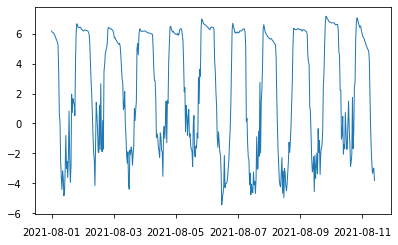

In [44]:
fig, ax = newfig(0.9)
ax.plot(m['datetime_utc'][:500], m['pred'][:500])
fig.show()

In [ ]:
FR-Mej 15.842077519103457
SE-Nor 8.199726969048575
FI-Ken 2.345923551560469
SE-Svb 3.3449358711303745
DK-Vng 8.204780240463325
DK-Gds 31.39743905314993
SE-Htm 14.884304187584362
DE-HoH 16.59860086507508
BE-Maa 4.499095279016071
DE-Har 7.89727608523204
FR-Aur 9.28509679929451
FI-Var 4.962857900028688
DE-Gri 13.212320960161042
DE-RuR 16.76988098855148
BE-Bra 16.524455569696787
BE-Vie 12.676401814015993
DE-Geb 15.13346324500395
DE-Kli 7.5926376167194185
DE-Obe 13.066222628845615
DE-Tha 10.425097788280162
NL-Loo 7.615324730366289
DE-Hai 6.148964701790413
DE-Lnf 8.58145098101285
DK-Sor 12.513197729073793
CH-Cha 33.747179229028056
CH-Fru 20.25972405430377
IT-MBo 8.065100393381915
IT-Tor 3.946241137291177
CH-Lae 31.106759326900963
FR-Gri 17.337961345641933
IT-Lav 30.98511105101038
IT-Ren 14.871594689161917
FR-Fon 17.814566448103623
IT-Ro2 13.012515250172783
IT-Noe 2.850891170976967
FI-Hyy 4.480011279245132
FI-Let 8.992115563578409
CZ-BK1 13.193553197707969
IT-Col 10.02720600332209

In [ ]:
FR-Mej 15.841852885781865
SE-Nor 8.197321980147876
FI-Ken 2.3452360632457823
SE-Svb 3.34417835106476
DK-Vng 8.20354621973716
DK-Gds 31.39928844223007
SE-Htm 14.879956793477444
DE-HoH 16.59734477446432
BE-Maa 4.499193561658521
DE-Har 7.8979374744817035
FR-Aur 9.285306213597158
FI-Var 4.9626185732591965
DE-Gri 13.211814380810312
DE-RuR 16.770369827781327
BE-Bra 16.526568961147365
BE-Vie 12.676728489944116
DE-Geb 15.134684061210425
DE-Kli 7.59443004347553
DE-Obe 13.06935946518229
DE-Tha 10.422553643729772
NL-Loo 7.614203747453944
DE-Hai 6.148690390799649
DE-Lnf 8.581053339145683
DK-Sor 12.512049664571364
CH-Cha 33.7480777202919
CH-Fru 20.259430261205775
IT-MBo 8.064712439732117
IT-Tor 3.946053786254416
CH-Lae 31.105309171111713
FR-Gri 17.334995507288657
IT-Lav 30.988019330360014
IT-Ren 14.872563072464454
FR-Fon 17.812968476416323
IT-Ro2 13.013788871740998
IT-Noe 2.8510121971697564
FI-Hyy 4.478610120310572
FI-Let 8.990353772777661
CZ-BK1 13.196736170728853
IT-Col 10.028322041601914